In [2]:
import os,tarfile,sys
sys.path.append('./Python_Script')

In [5]:
import ee 
import geemap
import numpy as np
import pandas as pd
import eerepr
import folium
import copy
import math
from tqdm import trange,tqdm
from functools import partial
import geopandas as gpd
from Correct_filter import *
geemap.set_proxy(port=10809)
ee.Authenticate()
ee.Initialize()
print('geemap version = {}\ngeemap path = {}'.format(geemap.__version__,geemap.__path__))

Enter verification code:  4/1AbUR2VOseEOdT1h7ggLE5aRq4mEnFtkRSHT60nP5b4MEom9giaZ6GLY2dng



Successfully saved authorization token.
geemap version = 0.20.0
geemap path = ['D:\\Wrz\\anaconda\\envs\\GEE\\lib\\site-packages\\geemap']


# 预加载藏东南切块与冰湖定位信息文件

In [6]:
Glacial_lake_2015A = ee.FeatureCollection(
    'projects/ee-mrwurenzhe/assets/Glacial_lake/Wu_Asia_Southest_GL_wgs84').filter(ee.Filter.gte('GL_Area', 0.1))
    #projects/ee-mrwurenzhe/assets/Glacial_lake/Checkout_polygen


# 计算geometry、质心点、最小包络矩形 
Geo_ext = lambda feature: feature.set({
    'Geo': feature.geometry(),
    'Centroid': feature.geometry().centroid(),
    'Rectangle': feature.geometry().bounds()
})
Centrid_set = lambda feature: feature.setGeometry(feature.geometry().centroid())
Rectangle_set = lambda feature: feature.setGeometry(feature.geometry().bounds())

Glacial_lake_2015C = Glacial_lake_2015A.map(Geo_ext).map(Centrid_set)  # 添加属性,修改geometry,计算质心
Glacial_lake_2015R = Glacial_lake_2015A.map(Rectangle_set)       # 计算最小包络矩形

#抽取属性作为list
Glacial_lake_2015A_GeoList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(), ['Geo']).get('list'))
Glacial_lake_2015C_CentriodList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(),['Centroid']).get('list'))
Glacial_lake_2015R_RectangleList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(),['Rectangle']).get('list'))
Num_list = Glacial_lake_2015C_CentriodList.size().getInfo()

# 根据质心点引入SAR和光学，升降轨，选择缓冲区

## S1滤波与选择函数定义

In [10]:
# 预定义函数
def make_dir(path):
    isExists = os.path.exists(path)
    # 判断结果
    if not isExists:
        os.makedirs(path)
        print(path + ' 创建成功')
    return path

def cut_geometry(geometry,block_size:float=0.05):
    '''
    block_size 定义方块大小(度)
    '''
    # 计算边界
    bounds = ee.List(ee.List(geometry.bounds().coordinates()).get(0))
    # 计算geometry的宽度和高度
    width = ee.Number(ee.List(bounds.get(2)).get(0)).subtract(ee.Number(ee.List(bounds.get(0)).get(0)))
    height = ee.Number(ee.List(bounds.get(2)).get(1)).subtract(ee.Number(ee.List(bounds.get(0)).get(1)))
    # 计算行和列的数量
    num_rows = height.divide(block_size).ceil()
    num_cols = width.divide(block_size).ceil()
    # 定义一个函数，用于生成512x512的方块
    def create_blocks(row, col):
        x_min = ee.Number(ee.List(bounds.get(0)).get(0)).add(col.multiply(block_size))
        y_min = ee.Number(ee.List(bounds.get(0)).get(1)).add(row.multiply(block_size))
        x_max = x_min.add(block_size)
        y_max = y_min.add(block_size)
        return ee.Geometry.Rectangle([x_min, y_min, x_max, y_max])

    # 生成方块列表
    block_list = []
    for row in range(num_rows.getInfo()):
        for col in range(num_cols.getInfo()):
            block = create_blocks(ee.Number(row), ee.Number(col))
            block_list.append(block)
    return block_list

def clip_AOI(col, AOI):
    return col.clip(AOI)

def time_difference(col, middle_date):
    time_difference = middle_date.difference(
        ee.Date(col.get('system:time_start')), 'days').abs()
    return col.set({'time_difference': time_difference})

def rm_nodata(col, AOI):
    # 将遮罩外的元素置-99,默认的遮罩为Nodata区域，并统计Nodata的数量
    allNone_num = col.select('VV_sigma0').unmask(-99).eq(-99).reduceRegion(
        **{
            'geometry': AOI,
            'reducer': ee.Reducer.sum(),
            'scale': 10,
            'maxPixels': 1e12,
            'bestEffort': True,
        }).get('VV_sigma0')
    return col.set({'numNodata': allNone_num})

def load_image_collection(aoi, start_date, end_date, middle_date,
                         dem=None,model=None,buffer=0,Filter=None,FilterSize=30):
    '''
    s1数据加载
    '''
    s1_col = (ee.ImageCollection("COPERNICUS/S1_GRD")
              .filter(ee.Filter.eq('instrumentMode', 'IW'))
                .filterBounds(aoi)
                .filterDate(start_date, end_date))
    # 图像滤波，可选
    if Filter:
        print('Begin Filter ...')
        if Filter == 'leesigma':
            s1_col = s1_col.map(leesigma(FilterSize))
        elif Filter == 'RefinedLee':
            s1_col = s1_col.map(RefinedLee)
        elif Filter == 'gammamap':
            s1_col = s1_col.map(gammamap(FilterSize))
        elif Filter == 'boxcar':
            s1_col = s1_col.map(boxcar(FilterSize))
        else:
            print('Wrong Filter')
    else:
        print('Without Filter')
        
    # 地形矫正，可选
    if dem and model:
        print('Begin Slop Correction ...')
        s1_col = slope_correction(s1_col, dem, model, buffer=buffer)
    else:
        Rename = lambda image:image.rename(['VV_sigma0', 'VH_sigma0','incAngle'])
        s1_col = s1_col.map(Rename)
        print('Without Slop Correction')
        
    # 裁剪并计算空洞数量
    s1_col = s1_col.map(partial(clip_AOI, AOI=aoi))
    s1_col = s1_col.map(partial(rm_nodata, AOI=aoi))

    # 计算与目标日期的差距
    s1_col = s1_col.map(partial(time_difference, middle_date=middle_date))
    
    # 删除角度波段select
    if model:
        pass
    else:
        s1_col = s1_col.map(lambda img: img.select(['VV_sigma0', 'VH_sigma0']))
      
    # 分离升降轨
    s1_descending = s1_col.filter(ee.Filter.eq(
        'orbitProperties_pass', 'DESCENDING'))
    s1_ascending = s1_col.filter(ee.Filter.eq(
        'orbitProperties_pass', 'ASCENDING'))
    
    # 如果所有图像都包含空洞则返回一张合成的图像，还需要重投影，否则计算会出错
    if s1_descending.filter(ee.Filter.eq('numNodata', 0)).size().getInfo() == 0:
        s1_descending = s1_descending.median().reproject(s1_descending.first().projection().getInfo()['crs'], None, 10).clip(aoi)
    else:
        s1_descending = s1_descending.filter(ee.Filter.eq('numNodata', 0))

    if s1_ascending.filter(ee.Filter.eq('numNodata', 0)).size().getInfo() == 0:
        s1_ascending = s1_ascending.median().reproject(s1_ascending.first().projection().getInfo()['crs'], None, 10).clip(aoi)
    else:
        s1_ascending = s1_ascending.filter(ee.Filter.eq('numNodata', 0))

    return s1_ascending, s1_descending

def Geemap_export(filename,collection=False,image=False,region=None,scale=10):
    if collection:
        # 这里导出时候使用region设置AOI，否则可能因为坐标系问题(未确定)，出现黑边问题
        geemap.ee_export_image_collection(collection,
                        out_dir=os.path.dirname(out_dir),
                        format = "ZIPPED_GEO_TIFF",region=region,scale=scale)
        print('collection save right')
    elif image:     
        geemap.ee_export_image(image,
                    filename=filename,
                    scale=scale, region=region, file_per_band=False,timeout=1500)
        print('image save right')
    else:
        print('Erro:collection && image must have one False')

## S2滤波参数

In [41]:
CLOUD_FILTER = 60                  # 过滤s2 大于指定云量的数据
CLD_PRB_THRESH = 15                # s2cloudless 概率值阈值[0-100],原实验是50
NIR_DRK_THRESH = 0.15              # 非水暗像素判断阈值
CLD_PRJ_DIST = 1                   # 根据 CLD_PRJ_DIST 输入指定的距离从云中投射阴影
BUFFER = 50                        # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input

def add_cloud_bands(img):
    """Define a function to add the s2cloudless probability layer
    and derived cloud mask as bands to an S2 SR image input."""
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    """Define a function to add dark pixels, 
    cloud projection, and identified shadows as bands to an S2 SR image input.
    Note that the image input needs to be the result of the above add_cloud_bands function
    because it relies on knowing which pixels are considered cloudy ('clouds' band)."""
    # 从 SCL 波段识别水像素, 仅适用于L2A，采用L1C计算MNDWI
    not_water = img.select('SCL').neq(6)

    # 识别非水的暗 NIR 像素(潜在的云阴影像素)。.
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # 确定云投射云影的方向(假设是 UTM 投影)。
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # 根据 CLD_PRJ_DIST 输入指定的距离从云中投射阴影
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')
    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    """
    添加cloud和shadow mask
    """
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()
    # Subset reflectance bands and update their masks, return the result.
    return img.select(['B.*','clouds','dark_pixels','shadows','cloudmask']).updateMask(not_cld_shdw)

def merge_s2_collection(aoi, start_date, end_date):
    """筛选S2图像以及S2_cloud图像，并将两个collection连接"""
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)).map(partial(clip_AOI,AOI=aoi)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date).map(partial(clip_AOI,AOI=aoi)))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    # 固定用法，将两个collection通过属性值连接起来，s2cloudless整体作为一个属性写入
    s2_sr_cld_col = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'})
    }))
    
    s2_sr_cld_col_disp = s2_sr_cld_col.map(add_cld_shdw_mask)
    # 使用clip赋予geometry
    s2_sr_median = s2_sr_cld_col_disp.map(apply_cld_shdw_mask).median().clip(aoi).int16()
    return s2_sr_cld_col_disp,s2_sr_median

## 获取影像(S1\S2)
获取冰湖的AOI范围，并获取相应的S1、S2图像

In [44]:
# 选择一个时间点的影像，注意SAR和光学影像的时间点已经不一样了
# 需要放宽一些时间限制，否则可能会因为天气影响、卫星维护等问题出现数据缺失
START_DATE  = ee.Date('2019-07-01')
END_DATE   = ee.Date('2019-08-30')
TIME_LEN   = END_DATE.difference(START_DATE, 'days').abs()
MIDDLE_DATE  = START_DATE.advance(TIME_LEN.divide(ee.Number(2)).int(),'days')
dem = ee.Image('USGS/SRTMGL1_003') # paths to dem 
models = ['volume', 'surface', None]     # 地形矫正模型

# 选择一个点做实验
i=1 #394(面积大) #53 #11(影像都用nodata) #149(坐标系问题)

AOI_point = ee.Feature.geometry(Glacial_lake_2015C_CentriodList.get(i))
AOI_area = ee.Feature.geometry(Glacial_lake_2015A_GeoList.get(i))
AOI = ee.Feature.geometry(Glacial_lake_2015R_RectangleList.get(i))

# 计算面积
AOI_area_area = AOI_area.area().divide(ee.Number(1000*1000)).getInfo()
# 缩小
if AOI_area_area < 1: 
    AOI_area_buffer = AOI_area.buffer(distance=AOI_area_area*-300)
else:
    AOI_area_buffer = AOI_area.buffer(distance=-400)
    
# 扩大包络矩形AOI,保证背景像素占比最大
if AOI_area_area < 1: 
    AOI_buffer = AOI.buffer(distance=300)
else:
    AOI_buffer = AOI.buffer(distance=400)

# 在这个点采用buffer裁剪文件，展示SAR，去除了包含空值的影像
s1_ascending,s1_descending = load_image_collection(AOI_buffer,START_DATE,END_DATE,MIDDLE_DATE,
                          dem=dem,model=models[2],Filter='RefinedLee',FilterSize=30)

# 全包含空值条件下，将图像集合合并为一张图像进行处理
if type(s1_ascending) == ee.imagecollection.ImageCollection:
    s1_single_a = s1_ascending.filter(ee.Filter.eq('time_difference', 
          s1_ascending.aggregate_min('time_difference'))).first().set({'synthesis': 0})
else:
    s1_single_a = s1_ascending.set({'synthesis': 1})
if type(s1_descending) == ee.imagecollection.ImageCollection:
    s1_single_d = s1_descending.filter(ee.Filter.eq('time_difference', 
          s1_descending.aggregate_min('time_difference'))).first().set({'synthesis': 0})
else:
    s1_single_d = s1_descending.set({'synthesis': 1})

# 加入条件空值，保证在空值情况下图像能够正常相加
condition = s1_single_d.mask().clip(AOI_buffer)
s1_unit_mean = s1_single_a.where(condition, s1_single_a.add(s1_single_d).divide(2)) #转为均值
s1_unit_max = s1_single_a.where(condition, s1_single_a.max(s1_single_d))
# s1_unit_add = s1_single_a.where(condition, s1_single_a.add(s1_single_d))

s1_unit_all = s1_unit_mean.addBands(s1_unit_max)

# 采用S2cloudless生产一张合成的无云图像
s2_sr_cld_col_disp,s2_sr_median = merge_s2_collection(AOI_buffer,ee.Date('2019-06-01'),ee.Date('2019-09-30'))

# 考虑在升降轨都表现为阴影的条件下(升降轨的夹角小，不足以满足在所有条件下阴影去除)

Begin Filter ...
Without Slop Correction


### 展示

In [13]:
Map = geemap.Map(basemap='HYBRID') # 
Map.centerObject(AOI_point, zoom=15)
# 原始图像
# Map.addLayer(s2_sr_median,{'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000, 'gamma': 2.0},'s2_sr_median')
# Map.addLayer(s1_single_a.select('VV_sigma0'),{'min':-40,'max':5},'s1_ascending_VV')
# Map.addLayer(s1_single_a.select('VH_sigma0'),{'min':-40,'max':5},'s1_ascending_VH')
# Map.addLayer(s1_single_d.select('VV_sigma0'),{'min':-40,'max':5},'s1_descending_VV')
# Map.addLayer(s1_single_d.select('VH_sigma0'),{'min':-40,'max':5},'s1_descending_VH')

# 几何畸变区
# Map.addLayer(s1_single_d.select('shadow'),{'min':0,'max':1},'shadow')
# Map.addLayer(s1_single_d.select('layover'),{'min':0,'max':1},'layover')

# 波段组合图像
Map.addLayer(s1_unit_mean.select('VV_sigma0'),{'min':-40,'max':5},'s1_unit_mean_VV')
# Map.addLayer(s1_unit_mean.select('VH_sigma0'),{'min':-40,'max':5},'s1_unit_mean_VH')
# Map.addLayer(s1_unit_add.select('VV_sigma0'),{'min':-40,'max':5},'s1_unit_add_VV')
# Map.addLayer(s1_unit_add.select('VH_sigma0'),{'min':-40,'max':5},'s1_unit_add_VH')
# Map.addLayer(s1_unit_max.select('VV_sigma0'),{'min':-40,'max':5},'s1_unit_max_VV')
# Map.addLayer(s1_unit_max.select('VH_sigma0'),{'min':-40,'max':5},'s1_unit_max_VH')

# 添加湖泊掩膜波段
Map.addLayer(AOI_area, {'color': 'blue'}, 'Polygon 2')
# Map.addLayer(AOI_area_buffer, {'color': 'red'}, 'Polygon 1')
Map.addLayer(AOI, {'color': 'green'}, 'Center')
Map.addLayer(AOI_point, {'color': 'red'}, 'Rectangle')

# 地形校正图像
# Map.addLayer(s1_single_d.select('VV_gamma0flat'),{'min':-40,'max':5},'s1_ascending_flat_VV')
# Map.addLayer(s1_single_d.select('VH_gamma0flat'),{'min':-40,'max':5},'s1_aescending_flatVH')
Map

Map(center=[27.513913573460574, 92.0488086761933], controls=(WidgetControl(options=['position', 'transparent_b…

#冰湖提取运算
> 针对点或者聚类的方法开展基于升降轨联合的Sentinel-1图像冰湖提取，对比多种方法，参考统计



## 图像增强（Sharpen）,似乎没啥用

> Difference of Gaussians (DoG)



In [14]:
# Create the Difference of Gaussians (DoG) kernel
fat = ee.Kernel.gaussian(radius=3, sigma=1, units='pixels')
skinny = ee.Kernel.gaussian(radius=3, sigma=0.5, units='pixels')

# Convolve the image with the Gaussian kernels
convolved_fat = s1_unit_all.convolve(fat)
convolved_skinny = s1_unit_all.convolve(skinny)

# Compute the Difference of Gaussians (DoG)
dog = convolved_fat.subtract(convolved_skinny)

# Add the DoG back to the original image
sharpened = s1_unit_all.add(dog)



> Laplacian 锐化



In [15]:
# Create the Laplacian kernel
laplacian_kernel = ee.Kernel.laplacian8(normalize=True)

# Apply the Laplacian kernel to the image
convolved = s1_unit_all.convolve(laplacian_kernel)

# Add the convolved image back to the original image
sharpened = s1_unit_all.add(convolved)

## 极化组合(后续工作，暂不进行)

## 特征优选(后续的工作，暂不进行)
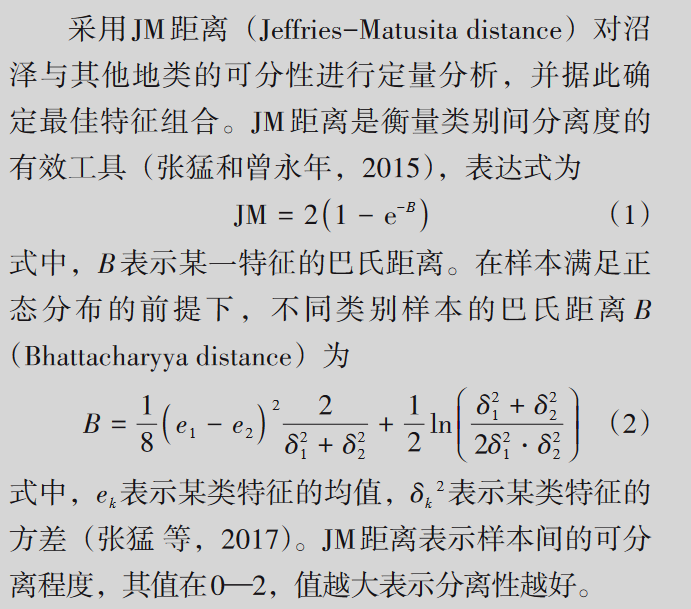

1. 从滤波器组合上进行优选滤波器
2. 从升降轨道联合上优选、单波段等
3. 从极化组合上优选
4. 从长时间尺度上提取藏东南冰湖面积变化




## 聚类与面向对象（多波段）

### 聚类

In [16]:
# Kmeans
def afn_Kmeans(inputImg,defaultStudyArea,numberOfUnsupervisedClusters=2,nativeScaleOfImage=10,numPixels=1000):
    '''
    inputImg：任何图像，所有波段将用于聚类。
    numberOfUnsupervisedClusters：要创建的聚类数的可调参数。
    defaultStudyArea：训练样本的默认区域。
    nativeScaleOfImage：图像的本地比例尺。
    '''
    # Make a new sample set on the inputImg. Here the sample set is randomly selected spatially.并训练
    training = inputImg.sample(region=defaultStudyArea, scale=nativeScaleOfImage, numPixels=numPixels)
    cluster = ee.Clusterer.wekaKMeans(numberOfUnsupervisedClusters).train(training)
    # Now apply that clusterer to the raw image that was also passed in.
    toexport = inputImg.cluster(cluster)
    # 选择分类结果，并进行重命名
    clusterUnsup = toexport.select(0).rename('unsupervisedClass')
    return clusterUnsup

def afn_Cobweb(inputImg,defaultStudyArea,cutoff=0.004,nativeScaleOfImage=10,numPixels=1000):
    # 这个算法效果一般
    training = inputImg.sample(region=defaultStudyArea, scale=nativeScaleOfImage, numPixels=numPixels)
    cluster = ee.Clusterer.wekaCobweb(cutoff=cutoff).train(training)
    toexport = inputImg.cluster(cluster)
    # 选择分类结果，并进行重命名
    clusterUnsup = toexport.select(0).rename('unsupervisedClass')
    return clusterUnsup

def afn_Xmeans(inputImg,defaultStudyArea,numberOfUnsupervisedClusters=2,nativeScaleOfImage=10, numPixels=1000):
    training = inputImg.sample(region=defaultStudyArea, scale=nativeScaleOfImage, numPixels=numPixels)
    cluster = ee.Clusterer.wekaXMeans(maxClusters=numberOfUnsupervisedClusters).train(training)
    toexport = inputImg.cluster(cluster)
    clusterUnsup = toexport.select(0).rename('unsupervisedClass')
    return clusterUnsup

def afn_LVQ(inputImg,defaultStudyArea,numberOfUnsupervisedClusters=2,nativeScaleOfImage=10, numPixels=1000):
    training = inputImg.sample(region=defaultStudyArea, scale=nativeScaleOfImage,numPixels=numPixels)
    cluster = ee.Clusterer.wekaLVQ(numClusters=numberOfUnsupervisedClusters).train(training)
    toexport = inputImg.cluster(cluster)
    clusterUnsup = toexport.select(0).rename('unsupervisedClass')
    return clusterUnsup

def afn_CascadeKMeans(inputImg,defaultStudyArea,numberOfUnsupervisedClusters=2,nativeScaleOfImage=10, numPixels=1000):
    training = inputImg.sample(region=defaultStudyArea, scale=nativeScaleOfImage, numPixels=numPixels)
    cluster = ee.Clusterer.wekaCascadeKMeans(maxClusters=numberOfUnsupervisedClusters).train(training)
    toexport = inputImg.cluster(cluster)
    clusterUnsup = toexport.select(0).rename('unsupervisedClass')
    return clusterUnsup

### 面向对象

In [17]:
# SNIC
def afn_SNIC(imageOriginal, SuperPixelSize=10, Compactness=1, Connectivity=4, NeighborhoodSize=20, SeedShape='square'):
    '''
    下面是对 afn_SNIC 函数的参数进行解释：
    imageOriginal: 要进行超像素分割的原始图像。这是必需的参数。
    SuperPixelSize: default=5意思是超像素大小，即生成的超像素的平均大小。通常情况下，该值取决于你要处理的图像的大小和分辨率。如果原始图像比较大，那么超像素的大小可以设置得较大，例如100或200像素。如果原始图像比较小，那么超像素的大小应设置得比较小，例如10或20像素。
    Compactness: default=1该参数控制着每个超像素的形态。它的值通常在[1,20]范围内取值。Compactness值越小，超像素类别的形状越规则，而 Compactness值越大，超像素的形状越灵活。
    Connectivity: default=8连通性参数，描述每个像素与周围像素的关系，这个参数通常设为8。
    NeighborhoodSize：瓦片邻域大小（为了避免瓦片边界伪影）。默认为2 * size。定义像素颜色在计算距离时考虑的领域大小。值越大，超像素越平滑，边缘越模糊；值越小，超像素分割边缘更为锐利。
    SeedShape：种子形状，可以是“square”或“hex”。
    '''
    theSeeds = ee.Algorithms.Image.Segmentation.seedGrid(SuperPixelSize, SeedShape)
    
    snic2 = ee.Algorithms.Image.Segmentation.SNIC(image=imageOriginal, 
                            size=SuperPixelSize, 
                            compactness=Compactness, 
                            connectivity=Connectivity, 
                            neighborhoodSize=NeighborhoodSize, 
                            seeds=theSeeds)
    theStack = snic2.addBands(theSeeds)
    return theStack

In [18]:
# 归一化
def afn_normalize_by_maxes(img,scale=10):
    '''
    注意：未进行重投影，max_\min_是地理坐标
    注意：使用使用
    img：要归一化的图像。
    bandMaxes：波段最大值。
    '''
    max_ = img.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=img.geometry(),
    scale=scale,
    maxPixels=1e12,
    bestEffort=True
    ).toImage().select(img.bandNames())

    min_ = img.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=img.geometry(),
        scale=scale,
        maxPixels=1e12,
        bestEffort=True
      ).toImage().select(img.bandNames()) #.reproject(img.select(0).projection().getInfo()['crs'], None, 10)

    return img.subtract(min_).divide(max_.subtract(min_))

###***运算式***

In [21]:
# 选择聚类方法，并展示与保存图像
# 注意投影，可能会导致图像结果出现差异
def Cluster_math(method:str,img,bands:list,index:str,visual:bool,save:bool,region=None):
    '''
    method ('Kmean','SNIC','SNIC_Kmean','LVQ','Xmeans','Cobweb','CascadeKMeans')
    '''
    img = img.select(bands)
    img = afn_normalize_by_maxes(img) # 归一化

    if method == 'Kmean' :
        result = afn_Kmeans(img,region)
    elif method == 'Cobweb':
        result = afn_Cobweb(img,region)
    elif method == 'Xmeans': 
        result = afn_Xmeans(img,region)
    elif method == 'LVQ':
        result = afn_LVQ(img,region)
    elif method == 'CascadeKMeans':
        result = afn_CascadeKMeans(img,region)
    elif method == 'SNIC':
        result = afn_SNIC(img)
        result = result.select(result.bandNames().removeAll(['clusters','seeds']))
        result = result.reproject(result.select(0).projection().getInfo()['crs'], None, 10) 
    elif method == 'SNIC_Kmean':
        result = afn_SNIC(img)
        # 默认舍弃cluster和seed    
        result = result.select(result.bandNames().removeAll(['clusters','seeds']))
        result = result.reproject(result.select(0).projection().getInfo()['crs'], None, 10) 
        result0 = afn_Kmeans(result,region)          # 原始图像不参与
        result1 = afn_Kmeans(result.addBands(img),region)   # 原始图像参与    .unmask(10)
    if visual:
        Map = geemap.Map(basemap='HYBRID') # 
        Map.centerObject(AOI_point, zoom=15)
        Map.addLayer(img, {'min':0.1,'max':0.8}, 'Origin')
        if method in ['Kmean','Cobweb','Xmeans','LVQ','CascadeKMeans']:
            Map.addLayer(result.randomVisualizer(), {}, method)
        elif method == 'SNIC':
            Map.addLayer(result.randomVisualizer(), {}, method)
        elif method == 'SNIC_Kmean':
            Map.addLayer(result0.randomVisualizer(), {}, 'SNIC_Kmean_NoOrigin')
            Map.addLayer(result1.randomVisualizer(), {}, 'SNIC_Kmean_YesOrigin')
        else:
            print('Please check your method str')
    else:
        Map = None
    if save:
        if method == 'SNIC_Kmean':
            Geemap_export(filename=index+'NoOrigin'+method+'.tif',collection=False,image=result0,region=region,scale=10)
            Geemap_export(filename=index+'YesOrigin'+method+'.tif',collection=False,image=result1,region=region,scale=10)
        else:
            Geemap_export(filename=index+method+'.tif',collection=False,image=result,region=region,scale=10)
    pass
    if method == 'SNIC_Kmean':
        return Map,result0.addBands(result1)
    else:
        return Map,result

In [22]:
Map,result=Cluster_math(method='Kmean',img=s1_unit_all,bands=[0,1],index='',visual=True,save=False,region=AOI_buffer)  # 如果迭代多个影像可以采用调整index
Map

Map(center=[27.513913573460574, 92.0488086761933], controls=(WidgetControl(options=['position', 'transparent_b…

## 阈值（单波段）

### 直方图统计阈值(OTSU)

In [26]:
def get_histogram(Image,region=None):
    histogram0 = Image.reduceRegion(
        reducer=ee.Reducer.histogram(1000),
        geometry=region,
        scale=10,
        maxPixels=1e12,
        bestEffort=True )#自动平衡scale减少计算量
    histogram = histogram0.get(Image.bandNames().get(0))
    return histogram

def afn_otsu(histogram):
    # 各组频数
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    # 各组的值
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    # 组数
    size = means.length().get([0])
    # 总像元数量
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    # 所有组的值之和
    sum_ = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    # 整幅影像的均值
    mean_ = sum_.divide(total)
    # 与组数相同长度的索引
    indices = ee.List.sequence(1, size)
    def calc_bss(i,sum_,mean_):
        '''穷举法计算类内方差''' 
        aCounts = counts.slice(0, ee.Number(i)) 
        # 从i分割为两类A、B 计算A方差
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0]) 
        aMeans = means.slice(0, ee.Number(i)) 
        # 类别A均值
        aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCount) 
        bCount = total.subtract(aCount) 
        # 类别B均值
        bMean = sum_.subtract(aCount.multiply(aMean)).divide(bCount)
        # 类间方差
        return aCount.multiply(aMean.subtract(mean_).pow(2)).add(bCount.multiply(bMean.subtract(mean_).pow(2)))
    # 计算类内方差
    bss = indices.map(partial(calc_bss,sum_=sum_,mean_=mean_))
    # 排序选出最适阈值
    return means.sort(bss).get([-1])

### 直方图双峰法

In [27]:
from skimage.filters import threshold_minimum
import numpy as np 

def afn_histPeak(img,region=None):
    '''
    采用skimage计算双峰
    参考论文：An analysis of histogram-based thresholding algorithms
    The analysis of cell images
    '''
    img = afn_normalize_by_maxes(img)
    img_numpy = geemap.ee_to_numpy(img,region=region)  #region必须是矩形
    threshold = threshold_minimum(img_numpy)
    return threshold

###***运算式***


In [28]:
def Bandmath(method:str,img,index:str,visual:bool,save:bool,region=None):
    '''
    method = ['otsu','threshould','histogram']
    img: 仅单波段图像
    '''
    assert len(img.bandNames().getInfo()) == 1 , '图像波段数必须唯一'
    img = afn_normalize_by_maxes(img) # 归一化

    if method == 'otsu':
        histogram = get_histogram(img,region=region)
        Threshould_value = afn_otsu(histogram)
        result = img.select(0).gt(Threshould_value)  #
        print('Threshould value is {}'.format(Threshould_value.getInfo()))  

    elif method == 'histPeak':
        Threshould_value = afn_histPeak(img,region=region)
        result = img.gt(Threshould_value)
        print('Threshould value is {}'.format(Threshould_value))

    if visual:
        Map = geemap.Map(basemap='HYBRID') # 
        Map.centerObject(AOI_point, zoom=15)
        if method in ['otsu','histPeak']:
            Map.addLayer(result.randomVisualizer(), {}, method)
        else:
            print('Wrong visual! Please check your method str')

    if save:
        if method in ['otsu','histPeak']:
            Geemap_export(filename=index+method+'.tif',collection=False,image=result,region=region,scale=10)
        else:
            print('Wrong save! Please check your method str')

    return Map,result
  
Map,result = Bandmath(method='histPeak',img=s1_unit_all.select(0),index='',visual=True,save=False,region=AOI,)
Map

Threshould value is 0.4488913657818062


Map(center=[27.513913573460574, 92.0488086761933], controls=(WidgetControl(options=['position', 'transparent_b…

## 监督分类（多波段）

### Randomforest

In [30]:
lake_feature = ee.Feature(AOI_area,{'class':1})
# 交集取反
AOI_difference = AOI_buffer.difference(AOI_area)
non_lake_feature = ee.Feature(AOI_difference,{'class':0})
training_data = ee.FeatureCollection([lake_feature, non_lake_feature])

In [31]:
# Sample the Sentinel-1 image collection using the training data
training_samples = s1_unit_add.sampleRegions(training_data, properties=['class'], scale=10)
# Train the classifier using the training samples
classifier = ee.Classifier.smileRandomForest(10).train(training_samples, 'class')

NameError: name 's1_unit_add' is not defined

In [ ]:
# Classify the Sentinel-1 image using the trained classifier
classified = s1_unit_add.classify(classifier)

In [ ]:
classified

In [ ]:
Map = geemap.Map(basemap='HYBRID') # 
Map.centerObject(AOI_area, 14)
Map.addLayer(AOI_buffer, {'color': 'red'}, 'Polygon 1')
Map.addLayer(AOI_area, {'color': 'blue'}, 'Polygon 2')
Map.addLayer(AOI_difference, {'color': 'green'}, 'Difference')
Map.addLayer(classified, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'Classification')
Map.addLayerControl()
Map

In [ ]:
lake_polygon = ee.Feature(Glacial_lake_2015C.toList(100).get(1)).set({'class': 1})

In [ ]:
# 求交集以外的区域，或者选点？

In [ ]:
Glacial_lake_2015A

In [ ]:
# Define the bands to be used for classification
bands = ['VV', 'VH']

# Load training data as a FeatureCollection
training_data = ee.FeatureCollection('users/your_username/training_data')

# Train the classifier using the training data
classifier = ee.Classifier.smileRandomForest(10).train(training_data, 'class', bands)

# Classify the Sentinel-1 image using the trained classifier
classified = sentinel1.select(bands).classify(classifier)

# Extract lakes from the classified image using a threshold
lakes = classified.eq(1)

In [ ]:
label = 'lake'
training = s1_unit_add.sampleRegions(
    **{'collection': AOI_area, 'properties': [label], 'scale': 10}
)

In [ ]:
print(training.first().getInfo())

In [ ]:
s1_unit_add

In [ ]:
AOI_area

In [ ]:
# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label)
result = s1_unit_add.classify(trained)

In [ ]:
Map = geemap.Map(basemap='HYBRID') # 
Map.centerObject(AOI_area, zoom=15)
Map.addLayer(AOI_area, {}, 'training', False)
Map.addLayer(result.randomVisualizer(), {}, 'classified')
Map

In [ ]:
# Use these bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']


# This property of the table stores the land cover labels.
label = 'lake'

# Overlay the points on the imagery to get training.
training = image.select(bands).sampleRegions(
    **{'collection': points, 'properties': [label], 'scale': 30}
)

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

In [ ]:
# 定义分类器，并加载训练集训练
classifier = ee.Classifier.smileRandomForest(10).train(training, label, bands)
# 使用训练好的classifier用于预测image
result = image.select(bands).classify(classifier)

# 后处理

## 先开(去除噪声)后闭(消除空洞)

> 膨胀(邻域内最大化) 腐蚀(邻域内最小化)



In [32]:
def Open_close(img,radius=10):
    uniformKernel = ee.Kernel.square(**{ 'radius': radius, 'units': 'meters'})
    min = img.reduceNeighborhood(**{'reducer': ee.Reducer.min(), 'kernel': uniformKernel })
    Openning = min.reduceNeighborhood(**{'reducer': ee.Reducer.max(), 'kernel': uniformKernel })
    max = Openning.reduceNeighborhood(**{'reducer': ee.Reducer.max(), 'kernel': uniformKernel })
    Closing = max.reduceNeighborhood(**{'reducer': ee.Reducer.min(), 'kernel': uniformKernel })
    return Closing

Map = geemap.Map(basemap='HYBRID') # 
Map.centerObject(AOI_point, zoom=15)
Map.addLayer(result.select(1).randomVisualizer(), {}, 'Origin')
Map.addLayer(Closing.randomVisualizer(), {}, 'Closing')
Map.addLayer(Openning.randomVisualizer(), {}, 'Openning')
Map

# 提取精度评价(考虑取到本地)


> 预先获取了20个准确的冰湖覆盖，并将矢量上传至GEE



## 保存图像

In [ ]:
def save_log(log,mode='gpd',crs='EPSG:4326',logname='log.csv',shapname='log.shp'):
    '''
    mode = 'pd' or 'gpd'
    '''
    if os.path.exists(logname):
        if mode == 'gpd':
            log.crs = crs
            log.to_file(shapname, driver='ESRI Shapefile', mode='a')
        log.to_csv(logname,mode='a',index=False,header=0)
    else:
    if mode == 'gpd':
        log.crs = crs
        log.to_file(shapname, driver='ESRI Shapefile', mode='w')
    log.to_csv(logname,mode='w',index=False)

def calculate_iou(geometry1, geometry2):
    intersection = geometry1.intersection(geometry2)
    union = geometry1.union(geometry2)
    intersection_area = intersection.area()
    union_area = union.area()
    return intersection_area.divide(union_area)

def image2vector(result,resultband=0,GLarea=1.,FilterBound=None):

  # 图像学运算，避免噪点过多，矢量化失败
  Closing_result = Open_close(result.select(resultband),radius=10)
  # 分类图转为矢量并删除背景，添加select(0)会减少bug，不晓得为啥
    if GLarea>20:
        Vectors = Closing_result.select(0).reduceToVectors(scale=30, geometryType='polygon', eightConnected=True)
    else:
        Vectors = Closing_result.select(0).reduceToVectors(scale=10, geometryType='polygon', eightConnected=True)
  
    Max_count = Vectors.aggregate_max('count')
    NoBackground_Vectors = Vectors.filterMetadata('count','not_equals',Max_count)
    # 提取分类结果,并合并为一个矢量
    Extract = NoBackground_Vectors.filterBounds(FilterBound)
    Union_ex = ee.Feature(Extract.union(1).first())
    return Union_ex

def write_pd(Union_ex,index,mode='gpd',Method='SNIC_Kmean',Band=[0,1,3],WithOrigin=0,pd_dict=None,
             Area_real=None,logname='log.csv',shapname='log.shp',calIoU=True):
    # 写入pandas
    Area_ = Union_ex.area().divide(ee.Number(1000*1000)).getInfo()
    if calIoU:
        IoU = calculate_iou(Union_ex,AOI_area).getInfo()
    else :
        IoU = False
  
    if mode == 'gpd':
        log = gpd.GeoDataFrame.from_features([Union_ex.getInfo()])
        log = log.assign(**{'Method':Method,
                            'Band':str(Band),
                            'WithOrigin':WithOrigin,
                            **pd_dict,
                            'Area_pre': [Area_], 
                            'Area_real':[Area_real],
                            'IoU':IoU,
                            'index':index})
    else:
        log = pd.DataFrame({'Method':Method,
                            'Band':str(Band),
                            'WithOrigin':WithOrigin,
                            **pd_dict,
                            'Area_pre': [Area_], 
                            'Area_real':[Area_real],
                            'IoU':IoU,}, 
                            index=[index])
  
    save_log(log,mode=mode,logname=logname,shapname=shapname)

Map = geemap.Map(basemap='HYBRID') # 
Map.centerObject(AOI_area_buffer, zoom=15)
Map.addLayer(Closing_result.randomVisualizer(), {}, 'Origin')
Map.addLayer(Vectors, {'color': 'blue'}, 'Polygon 2')
Map

### 用于预测

In [ ]:
os.chdir('/content/drive/My Drive/Output/2018预测数据')
Methods = ('SNIC_Kmean',)
resultbands = (0,1)
Bands = ([0,1],)
mode='gpd'
logname = 'preSNIC_Kmean.csv'
shpname = 'preSNIC_Kmean.shp'

for i in trange(Num_list):
    AOI_point = ee.Feature.geometry(Glacial_lake_2015C_CentriodList.get(i))
    AOI_area = ee.Feature.geometry(Glacial_lake_2015A_GeoList.get(i))
    AOI = ee.Feature.geometry(Glacial_lake_2015R_RectangleList.get(i))

    # 计算面积
    AOI_area_area = AOI_area.area().divide(ee.Number(1000*1000)).getInfo()
    # 缩小
    if AOI_area_area < 1: 
        AOI_area_buffer = AOI_area.buffer(distance=AOI_area_area*-300)
    else:
        AOI_area_buffer = AOI_area.buffer(distance=-400) 
    # 扩大包络矩形AOI,保证背景像素占比最大
    if AOI_area_area < 1: 
        AOI_buffer = AOI.buffer(distance=300)
    else:
        AOI_buffer = AOI.buffer(distance=400)
    # 在这个点采用buffer裁剪文件，展示SAR，去除了包含空值的影像
    s1_ascending,s1_descending = load_image_collection(AOI_buffer,START_DATE,END_DATE,MIDDLE_DATE,
                            dem=dem,model=models[2],Filter='RefinedLee',FilterSize=30)

    # 全包含空值条件下，将图像集合合并为一张图像进行处理
    if type(s1_ascending) == ee.imagecollection.ImageCollection:
        s1_single_a = s1_ascending.filter(ee.Filter.eq('time_difference', 
            s1_ascending.aggregate_min('time_difference'))).first().set({'synthesis': 0})
    else:
        s1_single_a = s1_ascending.set({'synthesis': 1})
    if type(s1_descending) == ee.imagecollection.ImageCollection:
        s1_single_d = s1_descending.filter(ee.Filter.eq('time_difference', 
            s1_descending.aggregate_min('time_difference'))).first().set({'synthesis': 0})
    else:
        s1_single_d = s1_descending.set({'synthesis': 1})

    # 加入条件空值，保证在空值情况下图像能够正常相加
    condition = s1_single_d.mask().clip(AOI_buffer)
    s1_unit_mean = s1_single_a.where(condition, s1_single_a.add(s1_single_d).divide(2)) #转为均值
    s1_unit_max = s1_single_a.where(condition, s1_single_a.max(s1_single_d))
    # s1_unit_add = s1_single_a.where(condition, s1_single_a.add(s1_single_d))
    s1_unit_all = s1_unit_mean.addBands(s1_unit_max)
    # 采用S2cloudless生产一张合成的无云图像
    s2_sr_median = merge_s2_collection(AOI_buffer,ee.Date('2019-06-01'),ee.Date('2019-09-30'))

    for Method in Methods:
        if Method == 'SNIC_Kmean':
            K = 2
        else:
            K = 1
        for k in range(K):
            resultband = resultbands[k]
            for Band in Bands:
                Map,result=Cluster_math(method=Method,img=s1_unit_all,bands=Band,index=''
                    ,visual=False,save=False,region=AOI_buffer) 

            if AOI_area_buffer.coordinates().getInfo() == []:
                FilterBound = AOI_area
            else:
                FilterBound = AOI_area_buffer
          
            # 分类图转矢量
            Union_ex = image2vector(result,
                        resultband=resultband,
                        GLarea=AOI_area_area,
                        FilterBound=FilterBound)
            if s1_single_d.get('synthesis').getInfo() == 0:
                d_name = s1_single_d.get('system:index').getInfo()
                d_date = s1_single_d.date().format('YYYY-MM-dd').getInfo()
                d_nodata = s1_single_d.get('numNodata').getInfo()
            else:
                d_name = 'None'; d_date = 'None' ; d_nodata='None'

            if s1_single_a.get('synthesis').getInfo() == 0:
                a_name = s1_single_a.get('system:index').getInfo()
                a_date = s1_single_a.date().format('YYYY-MM-dd').getInfo()
                a_nodata = s1_single_a.get('numNodata').getInfo()
            else:
                a_name = 'None'; a_date = 'None' ; a_nodata='None'
            pd_dict = {'a_name':a_name,'d_name':d_name,
                  'a_date':a_date,'d_date':d_date,
                  'a_nodata':a_nodata,'d_nodata':d_nodata}
      
            # 导出csv和shp
            write_pd(Union_ex,i,mode=mode,Method=Method,Band=Band,WithOrigin=resultband,pd_dict=pd_dict,
                  Area_real=AOI_area_area,logname=logname,shapname=shpname,calIoU=True)

            # 加入升降轨影像名称，加入升降轨影像成像日期，加入升降轨道空值像素个数
            if k == 0:
              # 导出图像
                try:
                    Geemap_export(filename=f'{i:04d}'+'_'+str(resultband)+'Ascending_'+a_name+'.tif',collection=False,image=s1_single_a,region=AOI_buffer,scale=10)
                    Geemap_export(filename=f'{i:04d}'+'_'+str(resultband)+'Descending_'+d_name+'.tif',collection=False,image=s1_single_d,region=AOI_buffer,scale=10)
                    Geemap_export(filename=f'{i:04d}'+'_'+str(resultband)+'s2a_sr_median'+'.tif',collection=False,image=s2_sr_median,region=AOI_buffer,scale=10)
                except:
                    dir_name = make_dir(f'{i:04d}')
                    block_list = cut_geometry(AOI_buffer)
                    for each in range(len(block_list)):
                        Geemap_export(filename=os.path.join(dir_name,f'{i:04d}'+'_'+str(resultband)+'Ascending_'+a_name+'.tif')
                                ,collection=False,image=s1_single_a,region=block_list[each],scale=10)
                        Geemap_export(filename=os.path.join(dir_name,f'{i:04d}'+'_'+str(resultband)+'Descending_'+d_name+'.tif')
                                ,collection=False,image=s1_single_d,region=block_list[each],scale=10)
                        Geemap_export(filename=os.path.join(dir_name,f'{i:04d}'+'_'+str(resultband)+'s2a_sr_median'+'.tif')
                                ,collection=False,image=s2_sr_median,region=block_list[each],scale=10)

In [ ]:
Map = geemap.Map(basemap='HYBRID') # 
Map.centerObject(AOI_buffer, zoom=15)
# Map.addLayer(Closing_result.randomVisualizer(), {}, 'Origin')
Map.addLayer(AOI_buffer, {'color': 'blue'}, 'Polygon 2')
Map.addLayer(test, {'color': 'red'}, 'Polygon 1')
Map.addLayer(test2, {'color': 'green'}, 'Polygon 3')
Map

In [ ]:
Geemap_export(filename=f'{i:04d}'+'_'+str(resultband)+'Ascending_'+a_name+'.tif',collection=False,image=s1_single_a,region=AOI_buffer,scale=10)

### 用于验证

In [ ]:
Methods = ('otsu','histPeak')#,'Cobweb'
resultbands = (0,1)
Bands = ([0],[1],[2],[3])
mode='gpd' # 'pd'
logname =  'log2.csv'
shpname =  'log2.shp'


Glacial_lake_2015A = ee.FeatureCollection(
    'projects/ee-mrwurenzhe/assets/Glacial_lake/Checkout_polygen')

Geo_ext = lambda feature: feature.set({
    'Geo': feature.geometry(),
    'Centroid': feature.geometry().centroid(),
    'Rectangle': feature.geometry().bounds()
})
Centrid_set = lambda feature: feature.setGeometry(feature.geometry().centroid())
Rectangle_set = lambda feature: feature.setGeometry(feature.geometry().bounds())

Glacial_lake_2015C = Glacial_lake_2015A.map(Geo_ext).map(Centrid_set)  # 添加属性,修改geometry,计算质心
Glacial_lake_2015R = Glacial_lake_2015A.map(Rectangle_set)       # 计算最小包络矩形

#抽取属性作为list
Glacial_lake_2015A_GeoList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(), ['Geo']).get('list'))
Glacial_lake_2015C_CentriodList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(),['Centroid']).get('list'))
Glacial_lake_2015R_RectangleList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(),['Rectangle']).get('list'))
Num_list = Glacial_lake_2015C_CentriodList.size().getInfo()
for i in trange(Num_list):
    AOI_point = ee.Feature.geometry(Glacial_lake_2015C_CentriodList.get(i))
    AOI_area = ee.Feature.geometry(Glacial_lake_2015A_GeoList.get(i))
    AOI = ee.Feature.geometry(Glacial_lake_2015R_RectangleList.get(i))

    # 计算面积
    AOI_area_area = AOI_area.area().divide(ee.Number(1000*1000)).getInfo()
    # 缩小
    AOI_area_buffer = AOI_area.buffer(distance=AOI_area_area*-400)
    # 扩大包络矩形AOI
    AOI_buffer = AOI.buffer(distance=300)

    # 在这个点采用buffer裁剪文件，展示SAR，去除了包含空值的影像
    s1_ascending,s1_descending = load_image_collection(AOI_buffer,START_DATE,END_DATE,MIDDLE_DATE,
                            dem=dem,model=models[2],Filter='RefinedLee',FilterSize=30)

    s1_single_a = s1_ascending.filter(ee.Filter.eq('time_difference',
                      s1_ascending.aggregate_min('time_difference'))).first()

    s1_single_d = s1_descending.filter(ee.Filter.eq('time_difference', 
                      s1_descending.aggregate_min('time_difference'))).first()

    s1_unit_add = s1_single_a.add(s1_single_d)
    s1_unit_max = s1_single_a.max(s1_single_d)

    s1_unit_all = s1_unit_add.addBands(s1_unit_max)
    for Method in Methods:
        if Method == 'SNIC_Kmean':
            K = 2
        else:
            K = 1
        for k in range(K):
            resultband = resultbands[k]
            for Band in Bands:
                # Map,result=Cluster_math(method=Method,img=s1_unit_all,bands=Band,index=''
                #             ,visual=False,save=False,region=AOI_buffer) 
                Map,result = Bandmath(method='histPeak',img=s1_unit_all.select(*Band),index=''
                            ,visual=True,save=False,region=AOI)
                if AOI_area_buffer.coordinates().getInfo() == []:
                    FilterBound = AOI_area
                else:
                    FilterBound = AOI_area_buffer
                Union_ex = image2vector(result,resultband=resultband,
                                  FilterBound=FilterBound)
                write_pd(Union_ex,i,mode=mode,Method=Method,Band=Band,WithOrigin=resultband,pd_dict={"":""},
                  Area_real=AOI_area_area,logname=logname,shapname=shpname,calIoU=True)

In [ ]:
os.getcwd()

In [ ]:
Methods = ('Kmean','SNIC_Kmean','LVQ','Xmeans','CascadeKMeans')#,'Cobweb'
resultbands = (0,1)
Bands = ([0],[1],[2],[3],[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,1,2],[0,1,3],[1,2,3],[0,1,2,3])
mode='gpd' # 'pd'
logname =  'log2.csv'
shpname =  'log2.shp'


Glacial_lake_2015A = ee.FeatureCollection(
    'projects/ee-mrwurenzhe/assets/Glacial_lake/Checkout_polygen')

Geo_ext = lambda feature: feature.set({
    'Geo': feature.geometry(),
    'Centroid': feature.geometry().centroid(),
    'Rectangle': feature.geometry().bounds()
})
Centrid_set = lambda feature: feature.setGeometry(feature.geometry().centroid())
Rectangle_set = lambda feature: feature.setGeometry(feature.geometry().bounds())

Glacial_lake_2015C = Glacial_lake_2015A.map(Geo_ext).map(Centrid_set)  # 添加属性,修改geometry,计算质心
Glacial_lake_2015R = Glacial_lake_2015A.map(Rectangle_set)       # 计算最小包络矩形

#抽取属性作为list
Glacial_lake_2015A_GeoList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(), ['Geo']).get('list'))
Glacial_lake_2015C_CentriodList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(),['Centroid']).get('list'))
Glacial_lake_2015R_RectangleList = ee.List(Glacial_lake_2015C.reduceColumns(ee.Reducer.toList(),['Rectangle']).get('list'))
Num_list = Glacial_lake_2015C_CentriodList.size().getInfo()
for i in trange(Num_list):
    AOI_point = ee.Feature.geometry(Glacial_lake_2015C_CentriodList.get(i))
    AOI_area = ee.Feature.geometry(Glacial_lake_2015A_GeoList.get(i))
    AOI = ee.Feature.geometry(Glacial_lake_2015R_RectangleList.get(i))

    # 计算面积
    AOI_area_area = AOI_area.area().divide(ee.Number(1000*1000)).getInfo()
    # 缩小
    AOI_area_buffer = AOI_area.buffer(distance=AOI_area_area*-400)
    # 扩大包络矩形AOI
    AOI_buffer = AOI.buffer(distance=300)

    # 在这个点采用buffer裁剪文件，展示SAR，去除了包含空值的影像
    s1_ascending,s1_descending = load_image_collection(AOI_buffer,START_DATE,END_DATE,MIDDLE_DATE,
                            dem=dem,model=models[2],Filter='RefinedLee',FilterSize=30)

    s1_single_a = s1_ascending.filter(ee.Filter.eq('time_difference',
                      s1_ascending.aggregate_min('time_difference'))).first()

    s1_single_d = s1_descending.filter(ee.Filter.eq('time_difference', 
                      s1_descending.aggregate_min('time_difference'))).first()

    s1_unit_add = s1_single_a.add(s1_single_d)
    s1_unit_max = s1_single_a.max(s1_single_d)

    s1_unit_all = s1_unit_add.addBands(s1_unit_max)
    for Method in Methods:
        if Method == 'SNIC_Kmean':
            K = 2
        else:
            K = 1
    for k in range(K):
        resultband = resultbands[k]
        for Band in Bands:
            Map,result=Cluster_math(method=Method,img=s1_unit_all,bands=Band,index=''
                    ,visual=False,save=False,region=AOI_buffer) 
        if AOI_area_buffer.coordinates().getInfo() == []:
            FilterBound = AOI_area
        else:
            FilterBound = AOI_area_buffer
        Union_ex = image2vector(result,resultband=resultband,
                              FilterBound=FilterBound)
        write_pd(Union_ex,i,mode=mode,Method=Method,Band=Band,WithOrigin=resultband,
              Area_real=AOI_area_area,logname=logname,shapname=shpname,calIoU=True)


# 一些舍弃掉的，可能还有意义的代码

## 双质心矢量分裂

> 一个不完善的寻找矢量中最窄部分，然后分裂矢量为两个


```
# 定义一个函数来计算两点之间的距离
def distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# 定义一个函数来找到最窄的部分
def find_narrowest_point(points):
    min_distance = float('inf')
    narrowest_point = None

    for i in range(len(points) - 1):


        dist = distance(points[i], points[i + 1])
        if dist < min_distance:
            min_distance = dist
            narrowest_point = i

    return narrowest_point

i = 0
Len_coor = len(coordinates)
i1 = i-Len_coor//4;i2 = i+ Len_coor//4
if i1<0:

if i1>0:
if i2<len(coordinates):
if i2>=len(coordinates):
coordinates[-2:]

# 提取矢量文件中的点坐标
coordinates=AOI_area.coordinates().getInfo()[0]
# 找到最窄的部分
narrowest_point = find_narrowest_point(coordinates)
# 将矢量文件分成两段
upper_half = coordinates[:narrowest_point + 1]
lower_half = coordinates[narrowest_point + 1:]
# 创建两个新的矢量文件
upper_half_feature = ee.Feature(ee.Geometry.LineString(upper_half))
lower_half_feature = ee.Feature(ee.Geometry.LineString(lower_half))
```
